## Demonstration of GAP range map evaluation framework

In [ ]:
%matplotlib inline

In [27]:
import sqlite3
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 60)
conn = sqlite3.connect('/users/nmtarr/documents/ranges/inputs/rng_eval_params.sqlite')
cursor = conn.cursor()
df = cursor.execute("SELECT * FROM column_descriptions").fetchall()
print('TABLE.COLUMN -->', 'DESCRIPTION,')
for row in df:
    print(row[0] + '.'+ row[1] + ' --> ' + row[2] + '\n')
    
conn.close()
del cursor

TABLE.COLUMN --> DESCRIPTION,
gbif_filters.filter_id --> Unique id for a combination of filtering parameters

gbif_filters.has_coordinate_uncertainty --> Should you remove records without coordinate uncertainty (1) or leave them in the data set (0).

gbif_requests.request_id --> Unique id for a combination of filtering parameters to use during a gbif data request.

gbif_requests.lat_range --> Range of latitudes within which to retrieve records.  Format is like -45,-35  .

gbif_requests.lon_range --> Range of longitudes within which to retrieve records.  Format is like 45,35  .

gbif_requests.years_range --> Range of years for which to include records.  Format is like 2001,2003  .

gbif_requests.months_range --> Range of months for which to include records.  Format is like 3,5  .

gbif_requests.geoissue --> Do you want to accept (True) records with georeferencing issues or not (False).

gbif_requests.coordinate_issue --> Do you want to accept (True) records with some sort of issue with 

downloading https://www.sciencebase.gov/catalog/file/get/59f5e201e4b063d5d307dc0f?f=__disk__89%2Fbb%2F19%2F89bb19045ef553fdf3a05056b81618649e77e351 to /Users/nmtarr/Documents/RANGES/Inputs/bYBCUx_CONUS_Range_2001v1.zip
downloading https://www.sciencebase.gov/catalog/file/get/59f5e201e4b063d5d307dc0f?f=__disk__db%2Fb5%2F9a%2Fdbb59a7ae14e77d87bd9a6f527f91dd55e577628 to /Users/nmtarr/Documents/RANGES/Inputs/bYBCUx_CONUS_Range_2001v1.xml
714 records exist


Text(0.5, 0.98, 'Yellow-billed Cuckoo occurrence polygons and GAP range (1970-2018)')

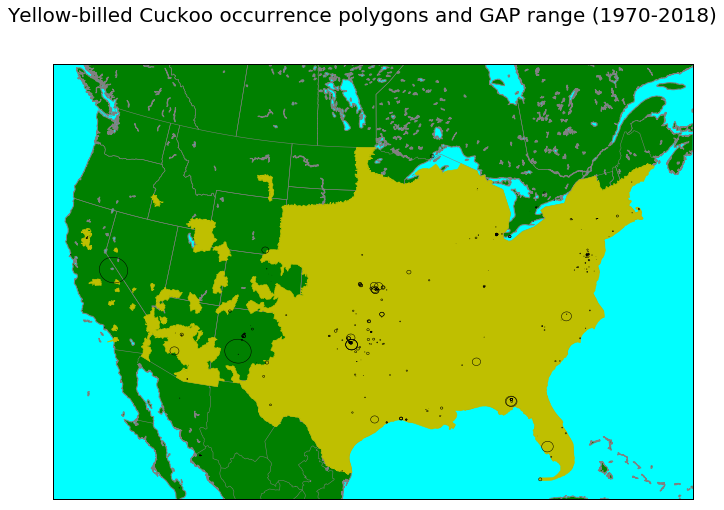

In [3]:
#############################################################################
#                               Configuration
#############################################################################
sp_id = 'bybcux0'
summary_name = 'cuckoo'
gbif_req_id = 'r001'
gbif_filter_id = 'f001'

workDir = '/Users/nmtarr/Documents/RANGES/'
codeDir = '/Users/nmtarr/Code/range_map_evaluation/'
inDir = workDir + 'Inputs/'
outDir = workDir + 'Outputs/'
# Used in file names for output.
SRID_dict = {'WGS84': 4326, 'AlbersNAD83': 102008}


#############################################################################
#                               Processing
#############################################################################
import pandas as pd
pd.set_option('display.width', 1000)
import sqlite3
import sciencebasepy
from pygbif import occurrences
import os
os.chdir('/')

#############################################################################
#                              Species-concept
#############################################################################
os.chdir(codeDir)
# Get species info from requests database
conn2 = sqlite3.connect(inDir + 'rng_eval_params.sqlite')
cursor2 = conn2.cursor()
sql_tax = """SELECT gbif_id, common_name, scientific_name,
                    detection_distance_meters, gap_id
             FROM species_concepts
             WHERE species_id = '{0}';""".format(sp_id)
concept = cursor2.execute(sql_tax).fetchall()[0]
gbif_id = concept[0]
common_name = concept[1]
scientific_name = concept[2]
det_dist = concept[3]
gap_id = concept[4]


#############################################################################
#                      GAP Range Data From ScienceBase
#############################################################################
def download_GAP_range_CONUS2001v1(gap_id, toDir):
    """
    Downloads GAP Range CONUS 2001 v1 file and returns path to the unzipped
    file.  NOTE: doesn't include extension in returned path so that you can
    specify if you want csv or shp or xml when you use the path.
    """
    import sciencebasepy
    import zipfile

    # Connect
    sb = sciencebasepy.SbSession()

    # Search for gap range item in ScienceBase
    gap_id = gap_id[0] + gap_id[1:5].upper() + gap_id[5]
    item_search = '{0}_CONUS_2001v1 Range Map'.format(gap_id)
    items = sb.find_items_by_any_text(item_search)

    # Get a public item.  No need to log in.
    rng =  items['items'][0]['id']
    item_json = sb.get_item(rng)
    get_files = sb.get_item_files(item_json, toDir)

    # Unzip
    rng_zip = toDir + item_json['files'][0]['name']
    zip_ref = zipfile.ZipFile(rng_zip, 'r')
    zip_ref.extractall(toDir)
    zip_ref.close()

    # Return path to range file without extension
    return rng_zip.replace('.zip', '')

gap_range = download_GAP_range_CONUS2001v1(gap_id, inDir)

# Reproject to WGS84 for displaying
conn3 = sqlite3.connect(':memory:')
os.putenv('SPATIALITE_SECURITY', 'relaxed')
conn3.enable_load_extension(True)
cursor3 = conn3.cursor()
sql_repro = """
SELECT load_extension('mod_spatialite');

SELECT InitSpatialMetadata();

SELECT ImportSHP('{0}{1}_conus_range_2001v1', 'rng3', 'utf-8', 5070,
                 'geom_5070', 'HUC12RNG', 'MULTIPOLYGON');

CREATE TABLE rng2 AS SELECT HUC12RNG, seasonCode, seasonName,
                            Transform(geom_5070, 4326) AS geom_4326 FROM rng3;

SELECT RecoverGeometryColumn('rng2', 'geom_4326', 4326, 'MULTIPOLYGON', 'XY');

SELECT ExportSHP('rng2', 'geom_4326', '{0}{1}_range_4326', 'utf-8');
""".format(inDir, gap_id)

cursor3.executescript(sql_repro)
conn3.close()
del cursor3

gap_range2 = "{0}{1}_range_4326".format(inDir, gap_id)


#############################################################################
#                           Create Occurrence Database
#############################################################################
"""
Description: Create a database for storing occurrence and species-concept
data.  Needs to have spatial querying functionality.
"""
# Delete the database if it already exists
spdb = outDir + sp_id + '_occurrences.sqlite'
if os.path.exists(spdb):
    os.remove(spdb)

# Create or connect to the database
conn = sqlite3.connect(spdb)
os.putenv('SPATIALITE_SECURITY', 'relaxed')
conn.enable_load_extension(True)
conn.execute('SELECT load_extension("mod_spatialite")')
cursor = conn.cursor()

# Make database spatial and add the spatial reference system that GAP used
conn.executescript('''SELECT InitSpatialMetaData();
             INSERT into spatial_ref_sys
             (srid, auth_name, auth_srid, proj4text, srtext)
             values (102008, 'ESRI', 102008, '+proj=aea +lat_1=20 +lat_2=60
             +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m
             +no_defs ', 'PROJCS["North_America_Albers_Equal_Area_Conic",
             GEOGCS["GCS_North_American_1983",
             DATUM["North_American_Datum_1983",
             SPHEROID["GRS_1980",6378137,298.257222101]],
             PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],
             PROJECTION["Albers_Conic_Equal_Area"],
             PARAMETER["False_Easting",0],
             PARAMETER["False_Northing",0],
             PARAMETER["longitude_of_center",-96],
             PARAMETER["Standard_Parallel_1",20],
             PARAMETER["Standard_Parallel_2",60],
             PARAMETER["latitude_of_center",40],
             UNIT["Meter",1],AUTHORITY["EPSG","102008"]]');''')
conn.commit()


################################################# Create tables
###############################################################
sql_cdb = """
        /* Create a table for occurrence records, WITH GEOMETRY */
        CREATE TABLE IF NOT EXISTS occurrences (
                occ_id INTEGER NOT NULL PRIMARY KEY UNIQUE,
                species_id INTEGER NOT NULL,
                source TEXT NOT NULL,
                source_sp_id TEXT NOT NULL,
                request_id TEXT NOT NULL,
                filter_id TEXT NOT NULL,
                coordinateUncertaintyInMeters INTEGER,
                occurrenceDate TEXT,
                retrievalDate TEXT NOT NULL DEFAULT CURRENT_TIMESTAMP,
                individualCount INTEGER DEFAULT 1,
                detection_distance INTEGER,
                radius_meters INTEGER,
                    FOREIGN KEY (species_id) REFERENCES taxa(species_id)
                    ON UPDATE RESTRICT
                    ON DELETE NO ACTION);

        SELECT AddGeometryColumn('occurrences', 'geom_4326', 4326, 'POINT',
                                 'XY');
"""
cursor.executescript(sql_cdb)


#############################################################################
#                            Get GBIF Records
#############################################################################
"""
Retrieve GBIF records for a species and save appropriate
attributes in the occurrence db.
"""
############################# RETRIEVE REQUEST PARAMETERS
# Up-front filters are an opportunity to lighten the load from the start.
sql_twi = """ SELECT lat_range FROM gbif_requests
              WHERE request_id = '{0}'""".format(gbif_req_id)
latRange = cursor2.execute(sql_twi).fetchone()[0]

sql_twi = """ SELECT lon_range FROM gbif_requests
              WHERE request_id = '{0}'""".format(gbif_req_id)
lonRange = cursor2.execute(sql_twi).fetchone()[0]

sql_twi = """ SELECT years_range FROM gbif_requests
              WHERE request_id = '{0}'""".format(gbif_req_id)
years = cursor2.execute(sql_twi).fetchone()[0]

sql_twi = """ SELECT months_range FROM gbif_requests
              WHERE request_id = '{0}'""".format(gbif_req_id)
months = cursor2.execute(sql_twi).fetchone()[0]

sql_twi = """ SELECT geoissue FROM gbif_requests
              WHERE request_id = '{0}'""".format(gbif_req_id)
geoIssue = cursor2.execute(sql_twi).fetchone()[0]

sql_twi = """ SELECT coordinate_issue FROM gbif_requests
              WHERE request_id = '{0}'""".format(gbif_req_id)
coordinate = cursor2.execute(sql_twi).fetchone()[0]

sql_twi = """ SELECT continent FROM gbif_requests
              WHERE request_id = '{0}'""".format(gbif_req_id)
continent = cursor2.execute(sql_twi).fetchone()[0]

#################### REQUEST RECORDS ACCORDING TO REQUEST PARAMS
# First, find out how many records there are that meet criteria
occ_search = occurrences.search(gbif_id,
                          year=years,
                          month=months,
                          decimelLatitude=latRange,
                          decimelLongitude=lonRange,
                          hasGeospatialIssue=geoIssue,
                          hasCoordinate=coordinate,
                          continent=continent)
occ_count=occ_search['count']
print('{0} records exist'.format(occ_count))

# Get occurrences in batches, saving into master list
alloccs = []
batches = range(0, occ_count, 300)
for i in batches:
    occ_json = occurrences.search(gbif_id,
                              limit=300,
                              offset=i,
                              year=years,
                              month=months,
                              decimelLatitude=latRange,
                              decimelLongitude=lonRange,
                              hasGeospatialIssue=geoIssue,
                              hasCoordinate=coordinate,
                              continent=continent)
    occs = occ_json['results']
    alloccs = alloccs + occs

# Pull out relevant attributes from occurrence dictionaries.  Filtering
# will be performed with info from these keys.
keykeys = ['basisOfRecord', 'individualCount', 'acceptedTaxonKey',
           'scientificName', 'acceptedScientificName','taxonomicStatus',
           'decimalLongitude', 'decimalLatitude',
           'coordinateUncertaintyInMeters', 'year',
           'month', 'day', 'eventDate', 'issues','geodeticDatum',
           'gbifID', 'type', 'preparations', 'occurrenceStatus',
           'georeferenceProtocol', 'georeferenceVerificationStatus',
           'occurrenceID']
alloccs2 = []
for x in alloccs:
    alloccs2.append(dict((y,x[y]) for y in x if y in keykeys))


##################################################  FILTER MORE
###############################################################
#  RETRIEVE FILTER PARAMETERS
sql_green = """SELECT has_coordinate_uncertainty FROM gbif_filters
               WHERE filter_id = '{0}';""".format(gbif_filter_id)
filt_coordUncertainty = cursor2.execute(sql_green).fetchone()[0]

# Remove if no coordinate uncertainty
if filt_coordUncertainty == 1:
    alloccs3 = [x for x in alloccs2 if 'coordinateUncertaintyInMeters'
                in x.keys()]
else:
    pass

########################
########################  WHAT ELSE CAN WE DO ??????...
########################  DEVELOP HERE
########################


###############################################  INSERT INTO DB
###############################################################
# Insert the records
for x in alloccs3:
    insert1 = []
    insert1.append((x['gbifID'], sp_id, 'gbif', x['acceptedTaxonKey'],
            x['coordinateUncertaintyInMeters'], x['eventDate'],
            gbif_req_id, gbif_filter_id))

    insert1 = tuple(insert1)[0]

    sql1 = """INSERT INTO occurrences ('occ_id', 'species_id', 'source',
                            'source_sp_id', 'coordinateUncertaintyInMeters',
                            'occurrenceDate', 'request_id', 'filter_id',
                            'geom_4326')
                VALUES {0}, GeomFromText('POINT({1} {2})',
                                            {3}))""".format(str(insert1)[:-1],
                x['decimalLongitude'], x['decimalLatitude'],
                SRID_dict[x['geodeticDatum']])
    cursor.executescript(sql1)

# Update the individual count when it exists
for e in alloccs3:
    if 'individualCount' in e.keys():
        sql2 = """UPDATE occurrences
            SET individualCount = {0}
            WHERE occ_id = {1};""".format(e['individualCount'], e['gbifID'])
        cursor.execute(sql2)
conn.commit()


################################################  BUFFER POINTS
###############################################################
# Buffer the x,y locations with the coordinate uncertainty
# in order to create circles.  Create versions in albers and wgs84.  The
# wgs84 version will be used in plotting with Basemap.  Buffer radius is
# the sum of detectiondistance from requests.species_concepts and
# coordinate uncertainty in meters here.
requestsDB = inDir + 'requests.sqlite'
sql_det = """
        ATTACH DATABASE '{0}' AS requests;

        UPDATE occurrences
        SET detection_distance = {1};

        UPDATE occurrences
        SET radius_meters = detection_distance + coordinateUncertaintyInMeters;

        DETACH DATABASE requests;
""".format(requestsDB, det_dist)
cursor.executescript(sql_det)

sql_buf = """
        /* Transform to albers (102008) and apply buffer */
        ALTER TABLE occurrences ADD COLUMN circle_albers BLOB;

        UPDATE occurrences SET circle_albers = Buffer(Transform(geom_4326,
                                                                102008),
                                                      radius_meters);

        /* The new geometry column needs an entry in the geometry columns
        table CAN THIS BE DONE WITH RecoverGeometryColumn???*/
        INSERT INTO geometry_columns (f_table_name, f_geometry_column,
                                      geometry_type, coord_dimension,
                                      srid, spatial_index_enabled)
                    VALUES ('occurrences', 'circle_albers', 3, 2, 102008, 0);

        /* Transform back to WGS84 so it can be displayed in iPython */
        ALTER TABLE occurrences ADD COLUMN circle_wgs84 BLOB;

        UPDATE occurrences SET circle_wgs84 = Transform(circle_albers, 4326);

        SELECT RecoverGeometryColumn('occurrences', 'circle_wgs84', 4326,
                                     'POLYGON', 'XY');
"""
cursor.executescript(sql_buf)


#################################################  DISPLAY MAPS
###############################################################
# Export occurrence circles as a shapefile (all seasons)
cursor.execute("""SELECT ExportSHP('occurrences', 'circle_wgs84',
                 '{0}{1}_circles', 'utf-8');""".format(outDir, summary_name))

# Export occurrence 'points' as a shapefile (all seasons)
cursor.execute("""SELECT ExportSHP('occurrences', 'geom_4326',
                  '{0}{1}_points', 'utf-8');""".format(outDir, summary_name))
conn.commit()
conn.close()
conn2.commit()
conn2.close()


# Packages needed for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

shp1 = {'file': gap_range2,
        'drawbounds': False, 'linewidth': .5, 'linecolor': 'y',
        'fillcolor': 'y'}

shp2 = {'file': '{0}{1}_circles'.format(outDir, summary_name),
        'drawbounds': True, 'linewidth': .5, 'linecolor': 'k',
        'fillcolor': None}

# Display occurrence polygons
map_these=[shp1, shp2]
title="Yellow-billed Cuckoo occurrence polygons and GAP range (1970-2018)"
"""
!!!!!!!!!!!!!!!!!!!!!!!!
BELOW CODE IS FROM config.MapPolygonsFromShp(), WHICH CRASHES KERNEL IN
FUNCTION FORM FOR SOME UNKNOWN REASON.
!!!!!!!!!!!!!!!!!!!!!!!!
"""
# Basemap
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
map = Basemap(projection='aea', resolution='i', lon_0=-95.5, lat_0=39.5,
              height=3400000, width=5000000)
map.drawcoastlines(color='grey')
map.drawstates(color='grey')
map.drawcountries(color='grey')
map.fillcontinents(color='green',lake_color='aqua')
map.drawmapboundary(fill_color='aqua')

for mapfile in map_these:
    # Add shapefiles to the map
    if mapfile['fillcolor'] == None:
        map.readshapefile(mapfile['file'], 'mapfile',
                          drawbounds=mapfile['drawbounds'],
                          linewidth=mapfile['linewidth'],
                          color=mapfile['linecolor'])
    else:
        map.readshapefile(mapfile['file'], 'mapfile',
                          drawbounds=mapfile['drawbounds'])
        # Code for extra formatting -- filling in polygons setting border
        # color
        patches = []
        for info, shape in zip(map.mapfile_info, map.mapfile):
            patches.append(Polygon(np.array(shape), True))
        ax.add_collection(PatchCollection(patches,
                                          facecolor= mapfile['fillcolor'],
                                          edgecolor=mapfile['linecolor'],
                                          linewidths=mapfile['linewidth'],
                                          zorder=2))
fig.suptitle(title, fontsize=20)